In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import joblib 
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from helpers import MLP
from ucimlrepo import fetch_ucirepo

#### Fetch the data from the UCI repo, the data comes in as two dataframes, one for features and one for the targets. We then concat them together to allow us to do some exploratory data analysis

In [2]:
data = fetch_ucirepo(id=2)

X = data.data.features
y = data.data.targets

data = pd.concat([X, y], axis=1)

data.to_csv('raw_data.csv')

#### Exploratory Data Analysis

In [3]:
print('Shape of Dataset - ', data.shape)
print("-----------------------------------------------")

Shape of Dataset -  (48842, 15)
-----------------------------------------------


In [4]:
print('Missing values in the Dataset - ')
print(data.isnull().sum())
print("-----------------------------------------------")

Missing values in the Dataset - 
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64
-----------------------------------------------


In [5]:
print("Summary statistics of the dataset:")
print(data.describe())

Summary statistics of the dataset:
                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


#### Using ? to replace blank values is a method found in a paper by Chakrabarty and Biswas (2018), the default marker reduces amount of data lost with the use of a unique category

In [7]:
data.fillna('?', inplace=True)



data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

#### Income value counts highlighted some issues with the data, we are expecting two different values but due to some formatting issues there are actually four different values. We clean the data to ensure we have the two values as expected

In [8]:
data['income'].value_counts()

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

In [9]:
data.loc[data['income'] == '<=50K.', 'income'] = '<=50K'
data.loc[data['income'] == '>50K.', 'income'] = '>50K'

In [10]:
data['income'].value_counts()

income
<=50K    37155
>50K     11687
Name: count, dtype: int64

#### Description of the numerical columns 

In [11]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


#### Description of only the categorical columns

In [12]:
data.describe(include=['O'])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,37155


#### Plotting the spread of high and low income values in the target column

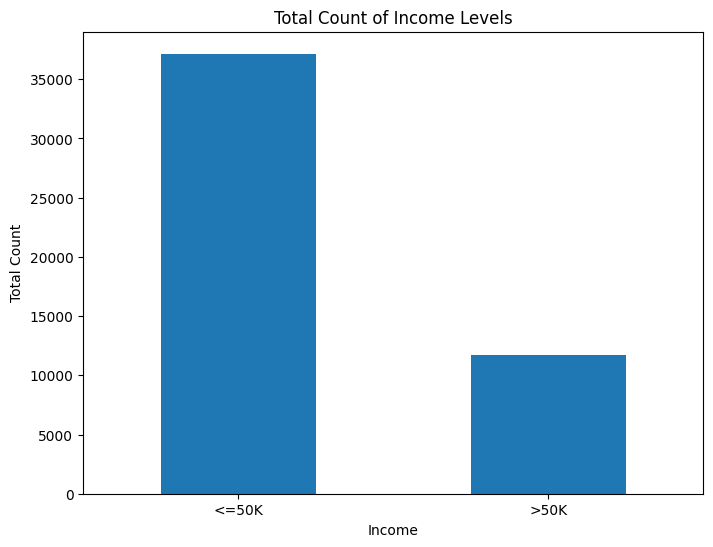

In [13]:
totals = data['income'].value_counts()

plt.figure(figsize=(8, 6))
totals.plot(kind='bar')
plt.title('Total Count of Income Levels')
plt.xlabel('Income')
plt.ylabel('Total Count')
plt.xticks(rotation=0)
plt.show()


#### Identifying correlation between the features

<Axes: >

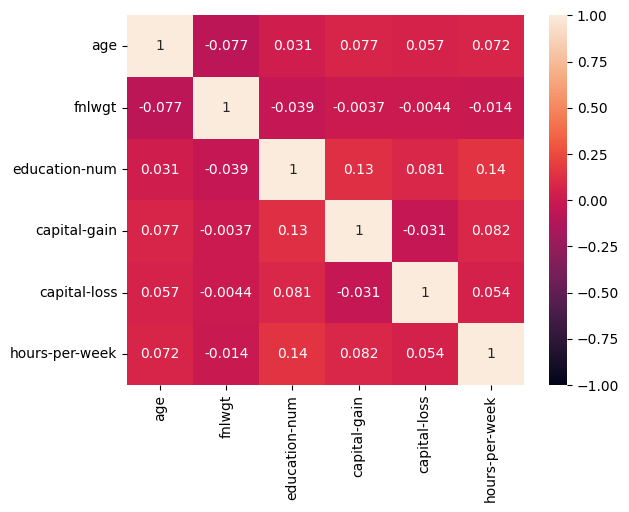

In [14]:
data_num = data.select_dtypes(include=np.number)
sns.heatmap(data_num.corr(),annot=True,vmin=-1, vmax=1)

#### Box and whisker plots to identify the distribution of the data and outliers

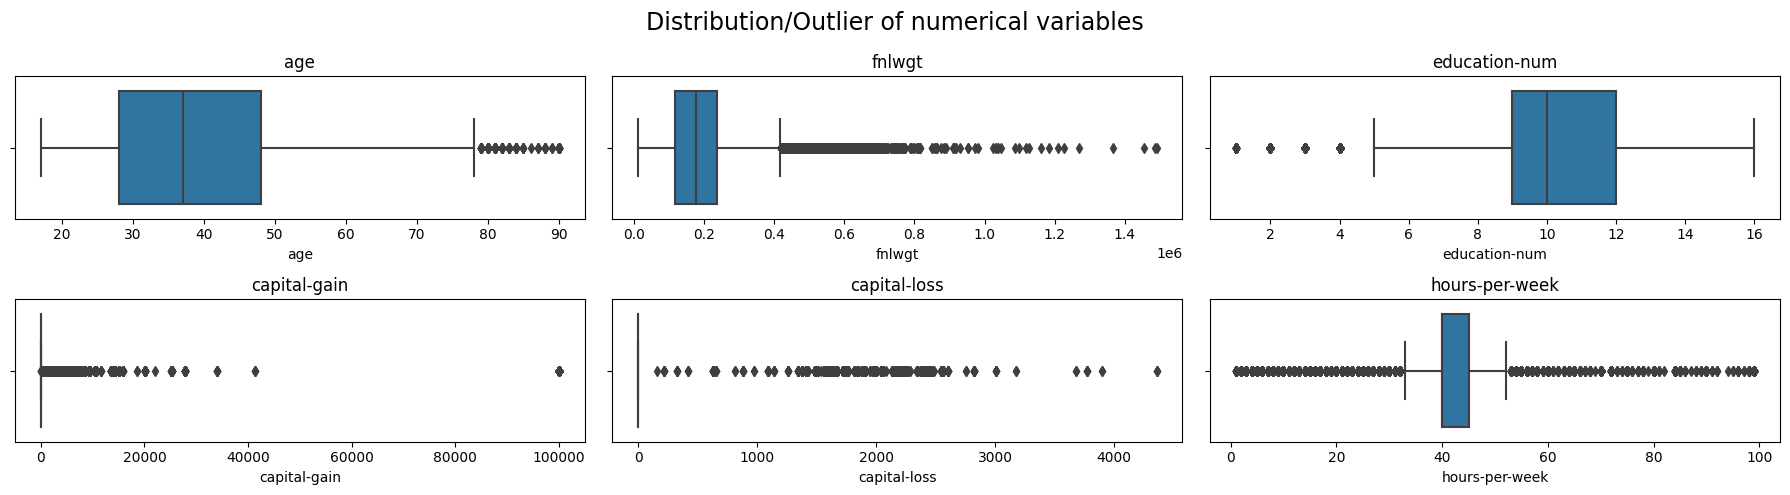

In [15]:
def plot_boxplot(data):
    
    numeric_columns = data.select_dtypes(include=np.number).columns.tolist()
    num_plots = len(numeric_columns)
    num_rows = (num_plots + 5) // 6  

    fig, axes = plt.subplots(2, 3, figsize=(18, 5 * num_rows))
    fig.suptitle('Distribution/Outlier of numerical variables', fontsize=17)

    axes = axes.flatten() if num_rows == 1 else axes

    for i, col in enumerate(numeric_columns):
        sns.boxplot(x=data[col], ax=axes[i])
        axes[i].set_title(col)

    plt.tight_layout()
    plt.show()

plot_boxplot(data)

#### Plotting the categorical columns, to help identify the spread of the data

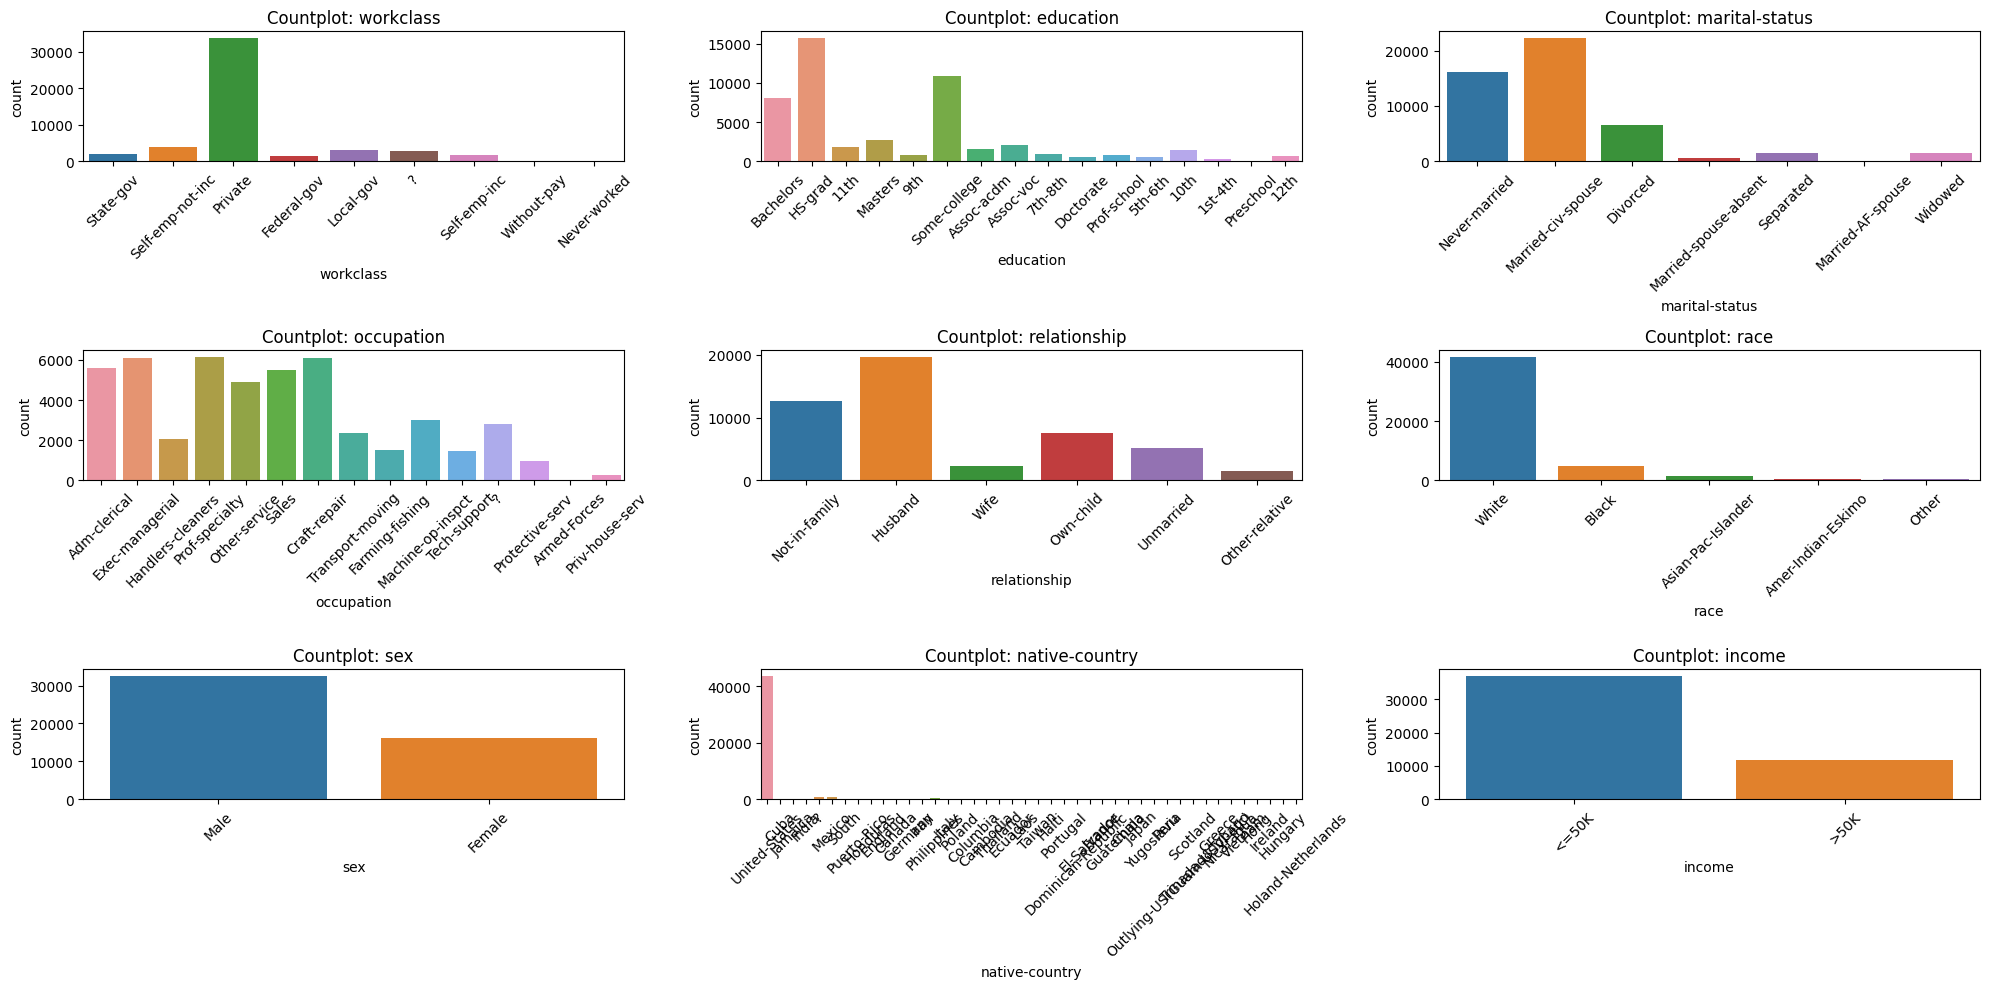

In [16]:
def plot_countplots(data, num_rows, num_cols, figsize):

    cat_columns = data.select_dtypes(include='object').columns

    num_cat_cols = len(cat_columns)

    fig, axis_rows = plt.subplots(num_rows, num_cols, figsize=figsize)

    axis_rows = axis_rows.flatten()

    for i in range(num_cat_cols):
        if i < len(axis_rows):
            sns.countplot(x=data[cat_columns[i]], ax=axis_rows[i])
            axis_rows[i].set_title(f'Countplot: {cat_columns[i]}')
            axis_rows[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
plot_countplots(data, 3, 3, (20,10))

In [17]:
data.drop(columns=['education-num'], inplace=True)

#### To encode the categorical columns we first used one hot encoding, this was after reading about the risk of overfitting with label encoding and also previous experience when switching from label encoding to one hot increased accuracy of a model. Once encoded the data is then split into X and y

In [18]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

data.to_csv('data.csv')

for column in X.select_dtypes(include=["object"]).columns:
    one_hot_encoded = pd.get_dummies(X[column], prefix=column, dtype='int')
    
    X = pd.concat([X, one_hot_encoded], axis=1)
    
    X.drop(column, axis=1, inplace=True)

y = y.map({'<=50K': 0, '>50K': 1})


X = X.values
y = y.values


print(X.shape)



(48842, 107)


#### Split the data into train and test sets using 30% of the data for the test set. A validation set wasn't used because the data is being split during the stratified KFold process

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


#### Normalise the data using the scikit learn StandardScaler to help prepare the data for training the multilayer perceptron and support vector machine. After this I will transform into tensors 

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32))
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))
y_train_tensor = torch.tensor(y_train.astype(np.float32)).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.astype(np.float32)).unsqueeze(1)

In [22]:
torch.save(X_test_tensor, 'X_test_tensor.pt')
torch.save(y_test_tensor, 'y_test_tensor.pt')

joblib.dump(X_test_scaled, 'X_test_scaled.pkl')
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']

#### MultiLayer Perceptron with two hidden layers. The model uses a ReLU activation function, ReLU is used here because it is efficient to compute and helps to speed up training
#### Then a sigmoid activiaton function is used between the hidden and output layer, squashing the values between 0 and 1 which is used for a binary classification task

In [24]:
torch.manual_seed(0)

y_train_tensor = y_train_tensor.to(torch.long)
y_test_tensor = y_test_tensor.to(torch.long)

net = NeuralNetClassifier(
    module=MLP,
    module__input_size=X_train_tensor.shape[1],
    module__output_size= 2,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    max_epochs=100,
    callbacks=[EarlyStopping()],
    optimizer__weight_decay=0.01

    
    
)



parameters = {
    'module__hidden_size': [64, 128, 256],  
    'lr': [0.001, 0.01, 0.1], 
    'optimizer__momentum': [0.0, 0.5, 0.9] 
}

grid_search = GridSearchCV(net, parameters, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train_tensor, y_train_tensor.flatten())



Fitting 5 folds for each of 27 candidates, totalling 135 fits


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5730       0.7619        0.5267  0.6145
      2        0.5154       0.8190        0.5029  0.7260
      3        0.4993       0.8365        0.4918  0.7199
      4        0.4906       0.8377        0.4861  0.7205
      5        0.4859       0.8381        0.4832  0.7106
      6        0.4833       0.8387        0.4814  0.7734
      7        0.4812       0.8391        0.4800  0.7335
      8        0.4806       0.8399        0.4793  0.7578
      9        0.4800       0.8407        0.4788  0.7407
     10        0.4782       0.8409        0.4782  0.7308
     11        0.4785       0.8426        0.4779  0.7460
     12        0.4778       0.8425        0.4776  0.7469
     13        0.4780       0.8424        0.4775  0.6833
     14        0.4776       0.8429        0.4774  0.7102
     15        0.4767       0.8428        0.4771  0.6759
     16        0.4763       0.8

GridSearchCV(cv=5,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'helpers.MLP'>,
  module__input_size=107,
  module__output_size=2,
),
             n_jobs=-1,
             param_grid={'lr': [0.001, 0.01, 0.1],
                         'module__hidden_size': [64, 128, 256],
                         'optimizer__momentum': [0.0, 0.5, 0.9]},
             scoring='accuracy', verbose=1)

In [25]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best Parameters - {best_params}")
print(f'Best Model - {best_model}')

results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']
params = results['params']

Best Parameters - {'lr': 0.1, 'module__hidden_size': 64, 'optimizer__momentum': 0.0}
Best Model - <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MLP(
    (dropout): Dropout(p=0.5, inplace=False)
    (fc1): Linear(in_features=107, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=2, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  ),
)


In [26]:
parameter_list = []
mean_score = []


results = grid_search.cv_results_

for mean, parameters in zip(results['mean_test_score'],  results['params']):
    parameter_list.append(parameters)
    mean_score.append(mean)



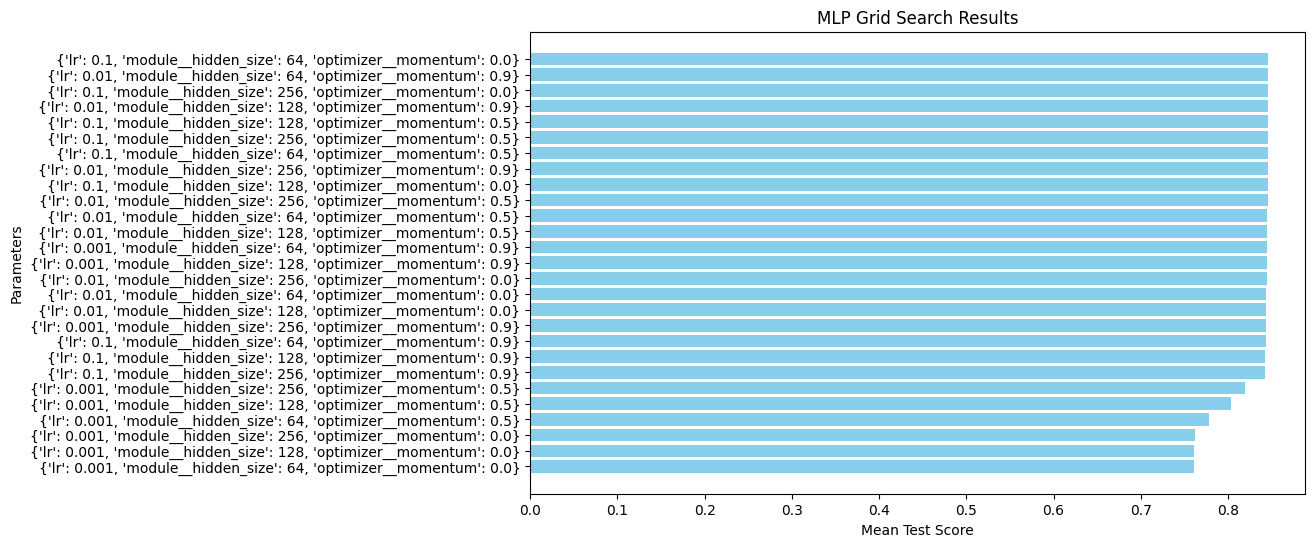

In [27]:
sorted_data = sorted(zip(parameter_list, mean_score), key=lambda x: x[1], reverse=True)

parameters_sorted, mean_scores_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
plt.barh(range(len(parameters_sorted)), mean_scores_sorted, color='skyblue')
plt.yticks(range(len(parameters_sorted)), [str(param) for param in parameters_sorted])
plt.xlabel('Mean Test Score')
plt.ylabel('Parameters')
plt.title('MLP Grid Search Results')
plt.gca().invert_yaxis()
plt.show()

In [28]:
y_pred = best_model.predict(X_test_tensor)
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy)

Accuracy: 0.8463113355626835


In [30]:
def train_eval_model(model_type, X_train_data, y_train_data, hidden_size=None, output_size=None, epochs=None, learning_rate=None, optimizer_momentum=None,  kernel=None, C=None, gamma=None):
    input_size = X_train_data.shape[1]  
  
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    training_accuracies = []
    validation_accuracies = []
    train_confusion_matrices = []
    validation_confusion_matrices = []
    
    
    train_mean_fpr = np.linspace(0, 1, 100)
    tprs_train = []
    val_mean_fpr = np.linspace(0, 1, 100)
    tprs_val = []
    
    fold_count = 1
    
    if model_type == 'MLP':
        
        model = NeuralNetClassifier(
            module=MLP,
            module__input_size = input_size,
            module__hidden_size = hidden_size,
            module__output_size = output_size,
            criterion = nn.CrossEntropyLoss,
            optimizer = torch.optim.SGD,
            optimizer__lr = learning_rate, 
            optimizer__momentum = optimizer_momentum,
            max_epochs = epochs,
            callbacks=[EarlyStopping(patience=10)],
            optimizer__weight_decay = 0.01
                       
        )
    
    elif model_type == 'SVM':
        
        model = SVC(kernel=kernel, C=C, gamma=gamma)
              
    
    for train_index, validation_index in k_fold.split(X_train_data, y_train_data):
        
        
        X_train_fold, X_val_fold = X_train_data[train_index], X_train_data[validation_index]
        y_train_fold, y_val_fold = y_train_data[train_index], y_train_data[validation_index]
        
        print(f'Fold - {fold_count}')
        
        if model_type == 'MLP':
        
            X_val_fold = torch.tensor(X_val_fold).to(torch.float32)
            
            y_train_fold = y_train_fold.squeeze()
            y_train_fold = y_train_fold.to(torch.long)
            y_val_fold = y_val_fold.squeeze()
            y_val_fold = y_val_fold.to(torch.long)
        
        model.fit(X_train_fold, y_train_fold)
        
        ## Calculating accuacies for training data
        
        y_train_prediction = model.predict(X_train_fold)

        training_accuracy = accuracy_score(y_train_prediction, y_train_fold)
        
        training_accuracies.append(training_accuracy)
    
        ## Confusion matrix for training data
               
        train_fold_confusion_matrix = confusion_matrix(y_train_fold, y_train_prediction)
        
        train_confusion_matrices.append(train_fold_confusion_matrix)
                
        ## ROC Curve for the training data
        
        fpr_train, tpr_train, _ = roc_curve(y_train_fold, y_train_prediction)
        tprs_train.append(np.interp(train_mean_fpr, fpr_train, tpr_train))
        tprs_train[-1][0] = 0.0
        
        ## Calculating accuracy for validation data
        
        y_val_prediction = model.predict(X_val_fold)

        val_accuracy = accuracy_score(y_val_prediction, y_val_fold)
        
        validation_accuracies.append(val_accuracy)
        
        ## Confusion matrix for validation dataa
        
        val_fold_confusion_matrix = confusion_matrix(y_val_prediction, y_val_fold)
        
        validation_confusion_matrices.append(val_fold_confusion_matrix)
        
        ## ROC curve for validation data    
        
        fpr_val, tpr_val, _ = roc_curve(y_train_fold, y_train_prediction)
        tprs_val.append(np.interp(val_mean_fpr, fpr_val, tpr_val))
        tprs_val[-1][0] = 0.0
        
        fold_count += 1
        
        
    mean_training_accuracy = np.mean(training_accuracies)

    mean_validation_accuracy = np.mean(validation_accuracies)

    train_summed_confusion_matrix = np.sum(train_confusion_matrices, axis=0)

    val_summed_confusion_matrix = np.sum(validation_confusion_matrices, axis=0)

    mean_tpr_train = np.mean(tprs_train, axis=0)

    mean_auc_train = auc(train_mean_fpr, mean_tpr_train)

    mean_tpr_val = np.mean(tprs_val, axis=0)

    mean_auc_val = auc(val_mean_fpr, mean_tpr_val)
    
    print(f'Mean Training accuracy - {mean_training_accuracy}. Validation accuracy - {mean_validation_accuracy}')
    
    plt.figure(figsize=(18, 12))

    plt.subplot(2, 2, 1)
    sns.heatmap(train_summed_confusion_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.title('Confusion Matrix (Training Dataset)')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')


    plt.subplot(2, 2, 2)
    plt.plot(train_mean_fpr, mean_tpr_train, color='b', label=f'Mean ROC (AUC = {mean_auc_train:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Training Dataset')
    plt.legend(loc='lower right')
    plt.grid(True)


    plt.subplot(2, 2, 3)
    sns.heatmap(val_summed_confusion_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.title('Confusion Matrix (Validation Dataset)')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')


    plt.subplot(2, 2, 4)
    plt.plot(val_mean_fpr, mean_tpr_val, color='b', label=f'Mean ROC (AUC = {mean_auc_val:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Validation Dataset')
    plt.legend(loc='lower right')
    plt.grid(True)



    plt.tight_layout()
    plt.show()
    
    return model    
    

Fold - 1


C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_81240\3579618490.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5857       0.7606        0.5362  0.6571
      2        0.5243       0.7690        0.5141  0.6315
      3        0.5075       0.8280        0.5000  0.6620
      4        0.4954       0.8366        0.4908  0.6695
      5        0.4892       0.8397        0.4861  0.8212
      6        0.4847       0.8401        0.4834  0.7112
      7        0.4827       0.8395        0.4820  0.6689
      8        0.4814       0.8399        0.4811  0.6684
      9        0.4804       0.8412        0.4801  0.6629
     10        0.4800       0.8412        0.4797  0.6763
     11        0.4785       0.8419        0.4791  0.7193


     12        0.4784       0.8417        0.4789  0.7759
     13        0.4779       0.8428        0.4787  0.9549
     14        0.4776       0.8435        0.4785  0.5501
     15        0.4779       0.8434        0.4783  0.5719
     16        0.4768       0.8430        0.4781  0.5709
     17        0.4768       0.8437        0.4782  0.6024
     18        0.4771       0.8428        0.4781  0.5895
     19        0.4768       0.8437        0.4780  0.5946
     20        0.4768       0.8435        0.4778  0.5006
     21        0.4762       0.8434        0.4779  0.5066
     22        0.4767       0.8428        0.4777  0.5666
     23        0.4762       0.8434        0.4775  0.5597
     24        0.4758       0.8435        0.4775  0.5811
     25        0.4766       0.8441        0.4776  0.6150
     26        0.4766       0.8439        0.4776  0.5830
     27        0.4760       0.8439        0.4776  0.5630
     28        0.4764       0.8445        0.4774  0.5426
     29        0.4757       0.8

C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_81240\3579618490.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5936       0.7606        0.5357  0.6345
      2        0.5253       0.7657        0.5134  0.6081
      3        0.5086       0.8254        0.4997  0.6462
      4        0.4965       0.8364        0.4905  0.5776
      5        0.4887       0.8379        0.4852  0.6137
      6        0.4853       0.8388        0.4826  0.5793
      7        0.4828       0.8392        0.4809  0.6529
      8        0.4808       0.8392        0.4798  0.6092
      9        0.4805       0.8382        0.4792  0.5895
     10        0.4787       0.8388        0.4787  0.6030
     11        0.4779       0.8397        0.4781  0.5674
     12        0.4775       0.8404        0.4777  0.6243
     13        0.4768       0.8406        0.4775  0.6089
     14        0.4767       0.8408        0.4772  0.5574
     15        0.4758       0.8406        0.4771  0.6235
     16        0.4762       0.8

C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_81240\3579618490.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5831       0.7606        0.5346  0.6080
      2        0.5242       0.7680        0.5142  0.6407
      3        0.5083       0.8231        0.5004  0.6682
      4        0.4962       0.8360        0.4909  0.6522
      5        0.4887       0.8392        0.4858  0.5475
      6        0.4856       0.8395        0.4830  0.6266
      7        0.4828       0.8390        0.4812  0.5848
      8        0.4808       0.8393        0.4799  0.5543
      9        0.4797       0.8404        0.4792  0.6044
     10        0.4788       0.8415        0.4787  0.5867
     11        0.4781       0.8415        0.4783  0.5624
     12        0.4774       0.8423        0.4779  0.6116
     13        0.4772       0.8424        0.4777  0.6121
     14        0.4772       0.8432        0.4774  0.5536
     15        0.4770       0.8437        0.4774  0.5461
     16        0.4766       0.8

C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_81240\3579618490.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5750       0.7606        0.5314  0.6033
      2        0.5215       0.7657        0.5135  0.5695
      3        0.5073       0.8214        0.5017  0.5989
      4        0.4978       0.8296        0.4936  0.6106
      5        0.4909       0.8324        0.4889  0.6379
      6        0.4875       0.8340        0.4862  0.6734
      7        0.4849       0.8346        0.4844  0.6222
      8        0.4830       0.8346        0.4832  0.6035
      9        0.4822       0.8362        0.4824  0.6291
     10        0.4811       0.8377        0.4816  0.5885
     11        0.4806       0.8375        0.4811  0.6100
     12        0.4794       0.8382        0.4806  0.5820
     13        0.4794       0.8382        0.4803  0.6253
     14        0.4800       0.8384        0.4803  0.6135
     15        0.4783       0.8386        0.4800  0.6451
     16        0.4788       0.8

C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_81240\3579618490.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5809       0.7609        0.5305  0.7009
      2        0.5208       0.7955        0.5082  0.6988
      3        0.5027       0.8348        0.4943  0.6933
      4        0.4924       0.8410        0.4865  0.6389
      5        0.4867       0.8410        0.4823  0.6211
      6        0.4836       0.8415        0.4802  0.6629
      7        0.4812       0.8437        0.4788  0.5959
      8        0.4803       0.8421        0.4779  0.6363
      9        0.4798       0.8435        0.4773  0.5627
     10        0.4793       0.8441        0.4769  0.6601
     11        0.4783       0.8437        0.4766  0.6510
     12        0.4772       0.8435        0.4761  0.6307
     13        0.4768       0.8443        0.4758  0.6001
     14        0.4770       0.8446        0.4756  0.6546
     15        0.4764       0.8434        0.4755  0.5895
     16        0.4761       0.8

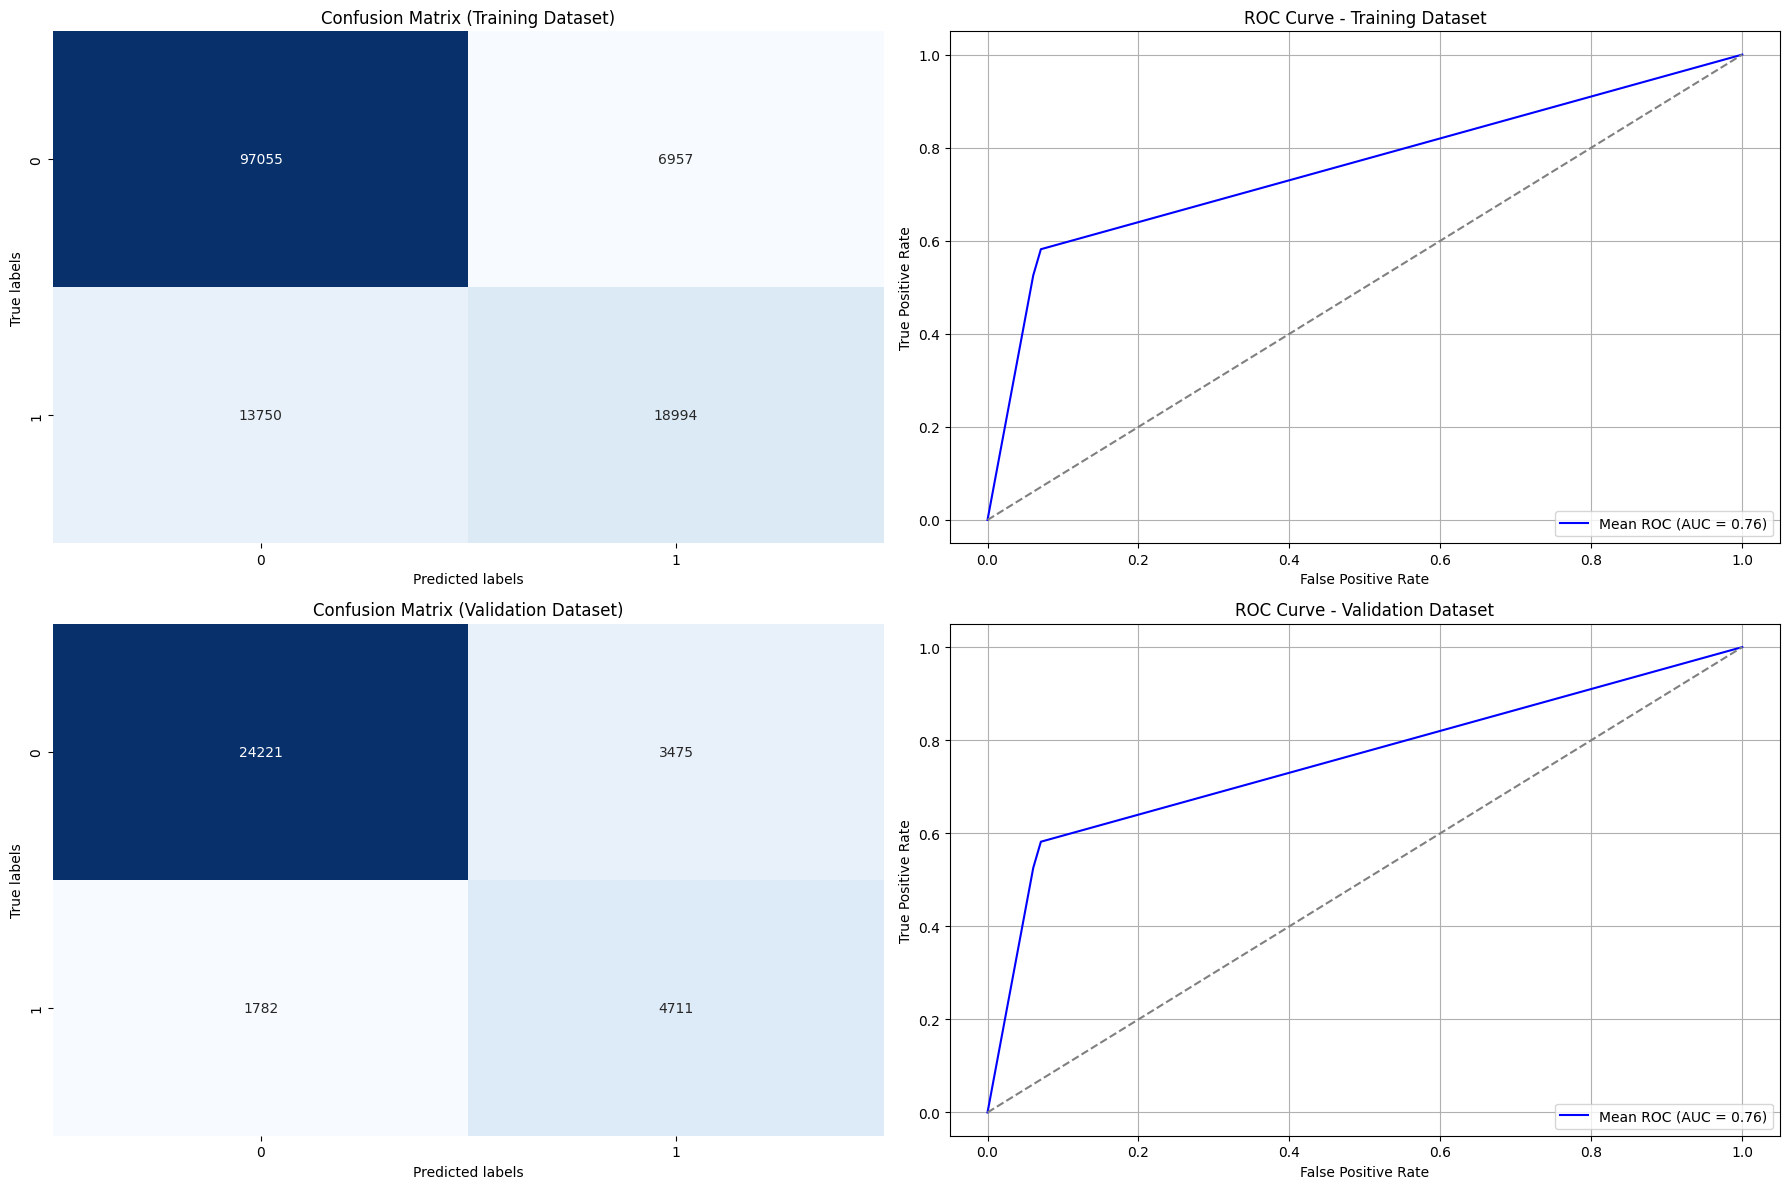

In [31]:
mlp = train_eval_model('MLP', X_train_tensor, y_train_tensor, hidden_size=64, output_size=2, epochs=250, learning_rate=0.01, optimizer_momentum=0.9)

#### Used SMOTE to resample the data due to the imbalance of the target variables. There are almost three times as many observations in the lower income category (<=50K) than the higher income (>50K)

In [33]:
smote = SMOTE()


X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

X_train_resampled = torch.tensor(X_train_resampled.astype(np.float32))
y_train_resampled = torch.tensor(y_train_resampled.astype(np.float32)).unsqueeze(1)


#### The function below is using resampled data to give more balanced number of values in the target data, the output wasn't good though, validation accuracy was low so may be overfitting

Fold - 1


C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_81240\3579618490.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4390       0.5001        0.7723  1.0818
      2        0.5076       0.5001        0.7733  1.2511


      3        0.5101       0.5001        0.7733  1.0812
      4        0.5098       0.5001        0.7733  0.9986
      5        0.5099       0.5001        0.7733  0.8570
      6        0.5096       0.5001        0.7733  0.8554
      7        0.5097       0.5001        0.7732  0.8551
      8        0.5097       0.5001        0.7733  0.8335
      9        0.5098       0.5001        0.7733  0.8592
     10        0.5098       0.5001        0.7732  0.7894
Stopping since valid_loss has not improved in the last 10 epochs.
Fold - 2
Re-initializing module because the following parameters were re-set: hidden_size, input_size, output_size.
Re-initializing criterion.
Re-initializing optimizer.


C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_81240\3579618490.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4387       0.4999        0.7726  0.9627
      2        0.5087       0.4999        0.7734  0.8630
      3        0.5107       0.4999        0.7735  0.8213
      4        0.5109       0.4999        0.7735  0.8472
      5        0.5109       0.4999        0.7735  0.8797
      6        0.5108       0.4999        0.7735  0.8224
      7        0.5107       0.4999        0.7735  0.8449
      8        0.5106       0.4999        0.7735  0.9013
      9        0.5105       0.4999        0.7735  0.7776
     10        0.5107       0.4999        0.7735  0.8781
Stopping since valid_loss has not improved in the last 10 epochs.
Fold - 3
Re-initializing module because the following parameters were re-set: hidden_size, input_size, output_size.
Re-initializing criterion.
Re-initializing optimizer.


C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_81240\3579618490.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4380       0.4999        0.7724  0.8533
      2        0.5079       0.4999        0.7733  0.8810
      3        0.5098       0.4999        0.7733  0.8401
      4        0.5100       0.4999        0.7734  0.8380
      5        0.5098       0.4999        0.7733  0.7556
      6        0.5097       0.4999        0.7733  0.8609
      7        0.5097       0.4999        0.7733  0.8903
      8        0.5096       0.4999        0.7734  0.8754
      9        0.5099       0.4999        0.7733  0.8441
     10        0.5095       0.4999        0.7733  0.8093
Stopping since valid_loss has not improved in the last 10 epochs.
Fold - 4
Re-initializing module because the following parameters were re-set: hidden_size, input_size, output_size.
Re-initializing criterion.
Re-initializing optimizer.


C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_81240\3579618490.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4355       0.4999        0.7567  0.8414
      2        0.5005       0.4999        0.7734  0.8469
      3        0.5094       0.4999        0.7735  0.8261
      4        0.5098       0.4999        0.7734  0.7568
      5        0.5096       0.4999        0.7735  0.8099
      6        0.5101       0.4999        0.7735  0.7768
      7        0.5099       0.4999        0.7734  0.8265
      8        0.5094       0.4999        0.7734  0.8553
      9        0.5092       0.4999        0.7734  0.8406
     10        0.5097       0.4999        0.7735  0.8920
Stopping since valid_loss has not improved in the last 10 epochs.
Fold - 5
Re-initializing module because the following parameters were re-set: hidden_size, input_size, output_size.
Re-initializing criterion.
Re-initializing optimizer.


C:\Users\Chris Henry\AppData\Local\Temp\ipykernel_81240\3579618490.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_fold = torch.tensor(X_val_fold).to(torch.float32)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4401       0.4999        0.7723  1.0285
      2        0.5074       0.4999        0.7731  0.9361
      3        0.5083       0.4999        0.7658  0.9358
      4        0.5076       0.4999        0.7732  0.9363
      5        0.5096       0.4999        0.7732  1.0417
      6        0.5098       0.4999        0.7731  1.2140
      7        0.5099       0.4999        0.7732  0.9371
      8        0.5095       0.4999        0.7732  0.9082
      9        0.5098       0.4999        0.7732  1.0388
     10        0.5097       0.4999        0.7732  1.0406
     11        0.5097       0.4999        0.7732  0.9828
     12        0.5098       0.4999        0.7732  1.0344
Stopping since valid_loss has not improved in the last 10 epochs.
Mean Training accuracy - 0.5. Validation accuracy - 0.5


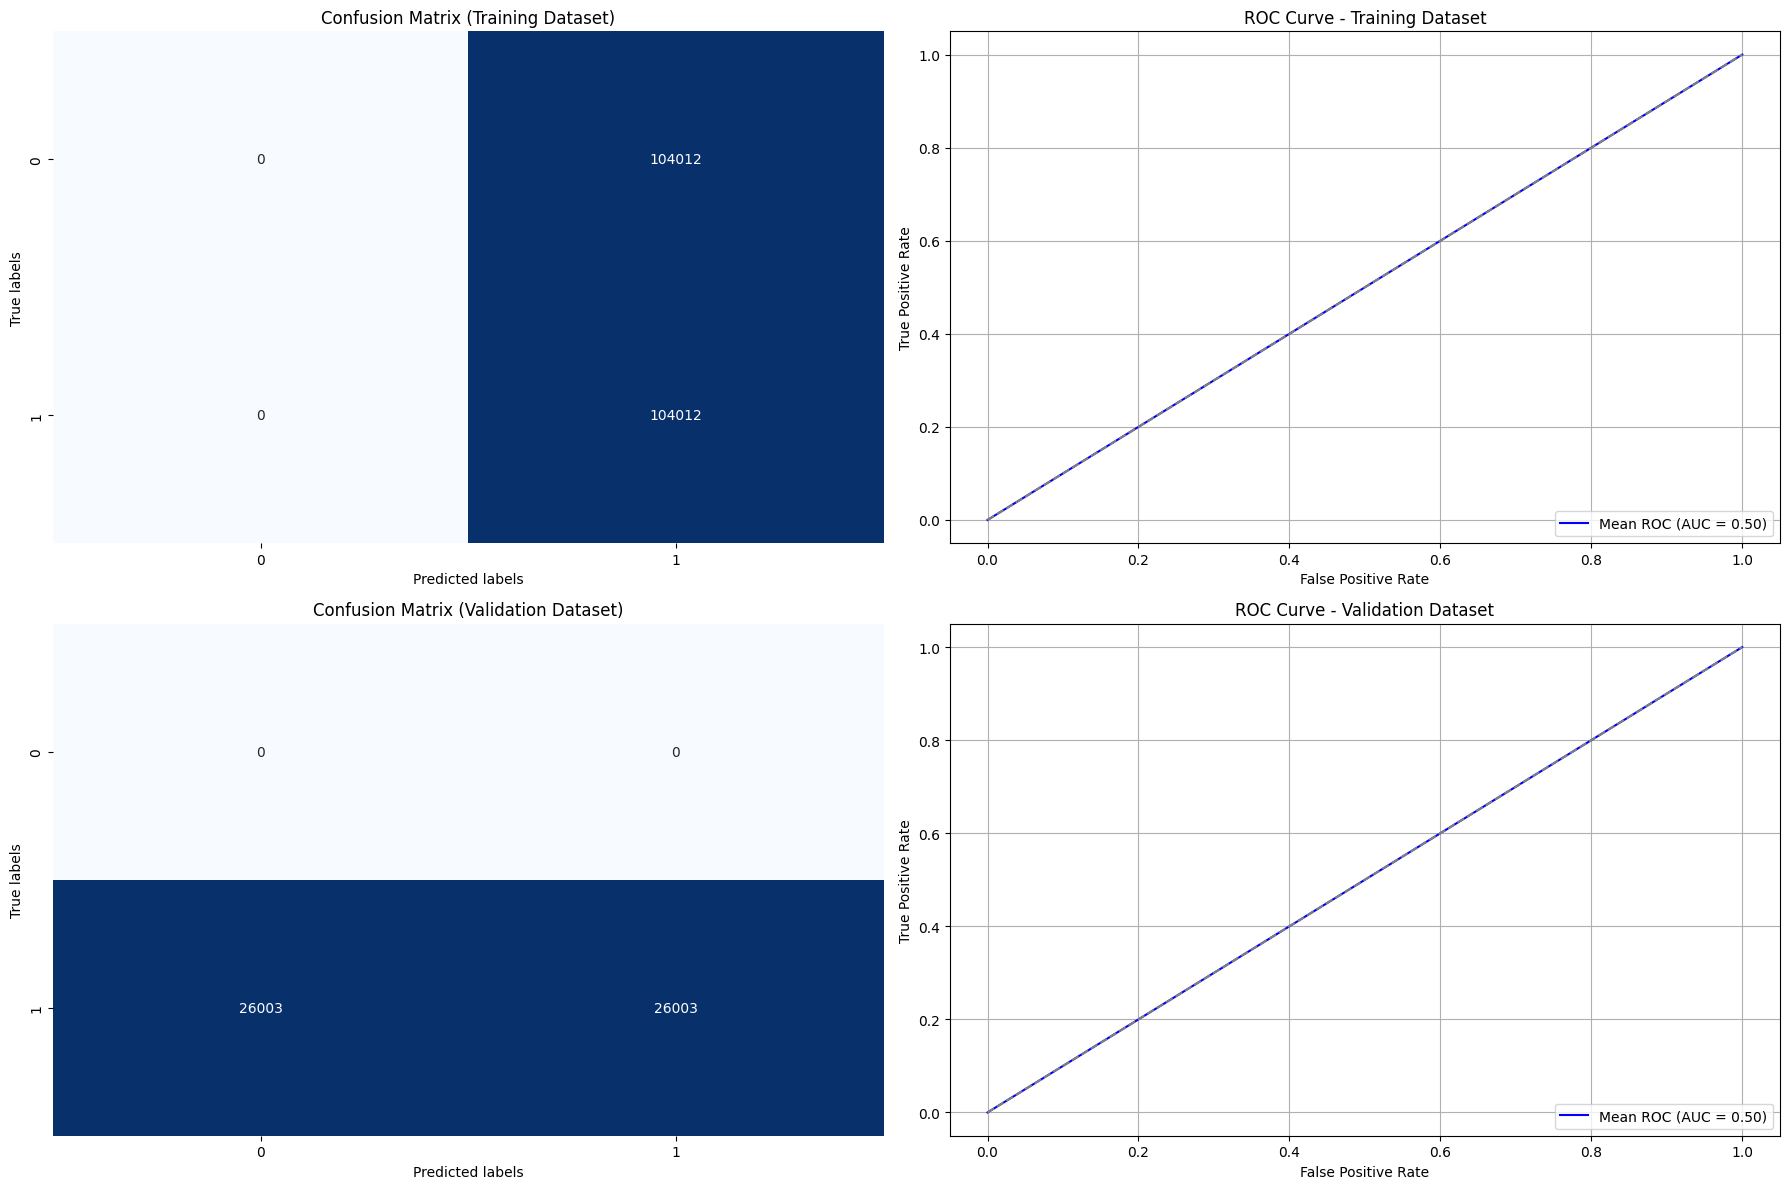

In [34]:
smote_model = train_eval_model('MLP', X_train_resampled, y_train_resampled, hidden_size=64, output_size=2, epochs=250, learning_rate=0.1, optimizer_momentum=0.9)

#### Conduct grid search to find best hyper parameters to use with support vector machine. Used RBF kernel as it is good for classification task so the two hyper parameters I was concerned with were C and gamma

In [35]:

param_grid = {
    'C': [0.1, 1, 10, 100], 
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'], 
    'kernel': ['rbf']
}


grid_search_svm = SVC()



grid_search = GridSearchCV(estimator=grid_search_svm, param_grid=param_grid, verbose=3, refit=True, cv=3, n_jobs=-1, error_score='raise')

grid_search.fit(X_train_scaled[:10000], y_train[:10000])


best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters - {best_params}")
print(f"Best Score - {best_score}")


test_score = grid_search.score(X_test_scaled, y_test)
print(f"Test Score - {test_score}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits


Best Parameters - {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best Score - 0.846600706861328
Test Score - 0.8515662321708866


In [36]:
parameter_list = []
mean_score = []


results = grid_search.cv_results_

for mean, parameters in zip(results['mean_test_score'],  results['params']):
    parameter_list.append(parameters)
    mean_score.append(mean)



#### Visualise the accuracy of the different hyper parameter settings, C - 10 and gamma - 0.001 were most accurate by a small margin

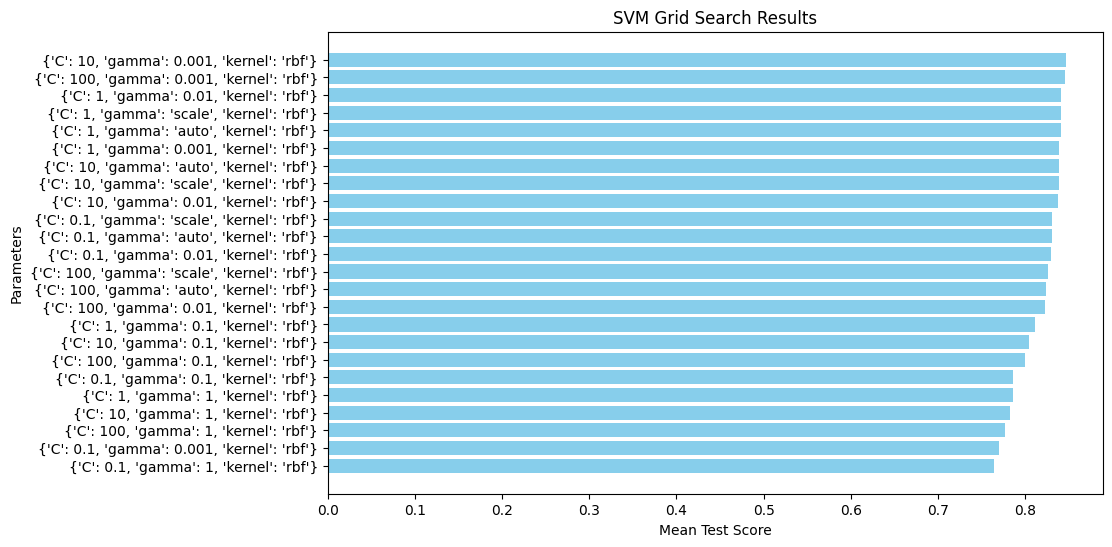

In [37]:
sorted_data = sorted(zip(parameter_list, mean_score), key=lambda x: x[1], reverse=True)

parameters_sorted, mean_scores_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
plt.barh(range(len(parameters_sorted)), mean_scores_sorted, color='skyblue')
plt.yticks(range(len(parameters_sorted)), [str(param) for param in parameters_sorted])
plt.xlabel('Mean Test Score')
plt.ylabel('Parameters')
plt.title('SVM Grid Search Results')
plt.gca().invert_yaxis()
plt.show()

#### Create a new SVM instance and train is on X and y training data, then predict how accurate the model is using SVM predict method. SVM doesn't train iteratively like a neural network so no need to use epochs here. Instead we are using StratifiedKFold, Stratifed was chosen over normal KFold because we want the ensure the proportion of observations in the target class matched the complete dataset. This is useful when one of the two classes is underrepresented, as is the case with our data

Fold - 1


Fold - 2
Fold - 3
Fold - 4
Fold - 5
Mean Training accuracy - 0.8614247239602413. Validation accuracy - 0.8524962949777383


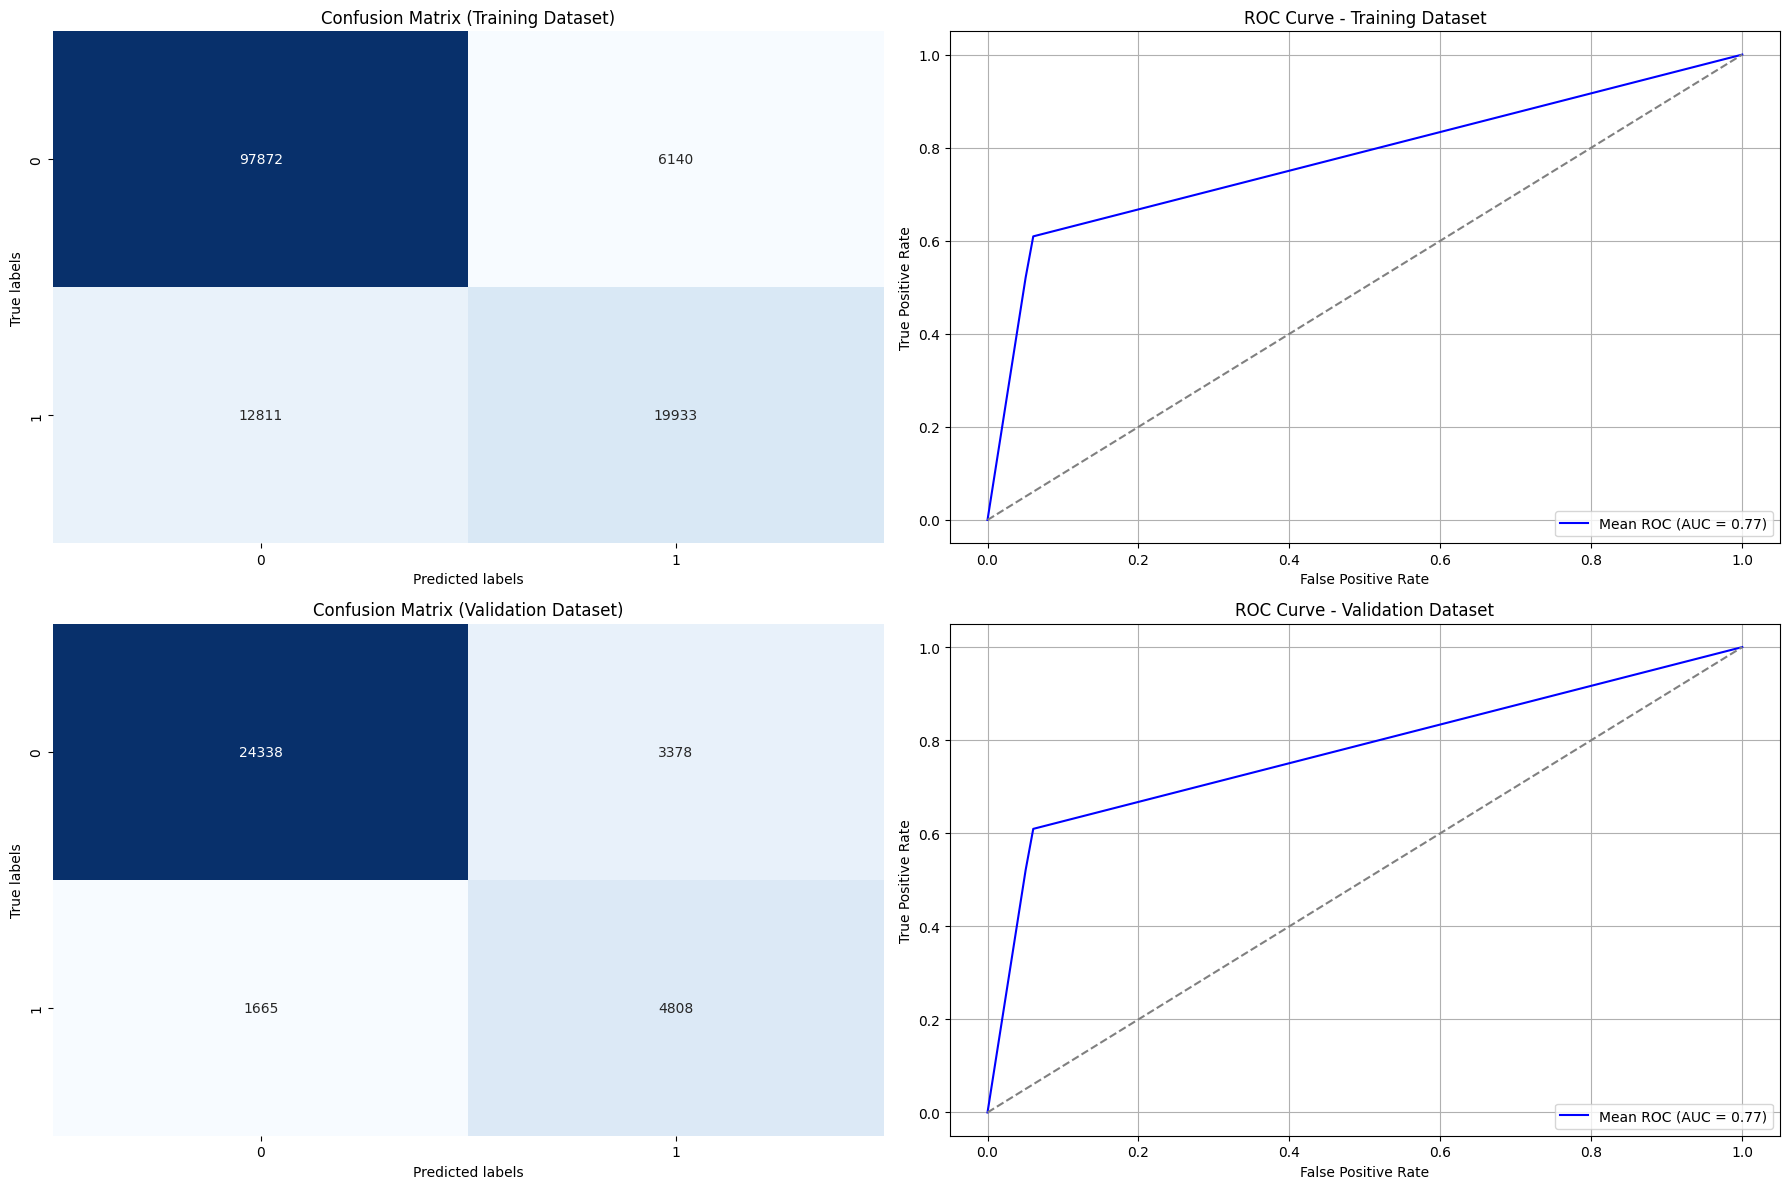

In [38]:
svm = train_eval_model('SVM', X_train_scaled, y_train, kernel='rbf', C=10, gamma=0.001)

In [43]:
joblib.dump(svm, 'trained_svm.pkl')

joblib.dump(mlp, 'trained_mlp.pkl')

['trained_mlp.pkl']